<a href="https://colab.research.google.com/github/ynusinovich/streamflow-prediction/blob/main/ARE/HYSETS_DARTS_training_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')
data_root = '/content/drive/My Drive/Streamflow Data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
# !pip install pyyaml==5.4.1
!pip install xarray==0.18.2
!pip install torch==1.8.1  # there appears to be a version conflict with the current version of pytorch and cuDNN
!pip install darts==0.21.0
!pip install -U matplotlib==3.1.3
# !pip install cudnn==8.3.2

import xarray as xr
import pandas as pd
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached torch-1.8.1-cp37-cp37m-manylinux1_x86_64.whl (804.1 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1
    Uninstalling torch-1.12.1:
      Successfully uninstalled torch-1.12.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.13.1+cu113 requires torch==1.12.1, but you have torch 1.8.1 which is incompatible.
torchtext 0.13.1 requires torch==1.12.1, but you have torch 1.8.1 which is incompatible.
torchaudio 0.12.1+cu113 requires torch==1.12.1, but you have torch 1.8.1 which is incompatible.
pytorch-lightning 1.7.7 requires torch>=1.9.*, but you have torch 1.8.1 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached torch-1.12.1-cp37-cp37m-manylinux1_x86_64.whl (776.3 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.8.1
    Uninstalling torch-1.8.1:
      Successfully uninstalled torch-1.8.1


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 4.6 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.3
    Uninstalling matplotlib-3.5.3:
      Successfully uninstalled matplotlib-3.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nfoursid 1.0.1 requires matplotlib>=3.3, but you have matplotlib 3.1.3 which is incompatible.
darts 0.21.0 requires matplotlib>=3.3.0, but you have matplotlib 3.1.3 which is incompatible.


In [4]:
#@title Load Pickled Data

import gzip, pickle

ts_version = 3

lscale = True
lcrop = True

if ts_version == 1: ver_str = ''
else: ver_str = f'_v{ts_version}'

pickle_name = "hysets_preprocessed_timseries{}{}{}.gz".format('_scaled' if lscale else '',
                                                            '_crop' if lcrop else '', ver_str)

with gzip.open(data_root+pickle_name, 'rb') as gz:
    pickle_dict = pickle.load(gz)

if lscale:
    # load scaled timeseries
    ts_series_train = pickle_dict['ts_train_scaled']
    cov_series_train = pickle_dict[ 'cov_train_scaled']
    ts_series_test = pickle_dict['ts_test_scaled']
    cov_series_test = pickle_dict['cov_test_scaled']
    # also load scalers and stats
    static_scaler = pickle_dict['static_scaler']
    ts_series_scaler = pickle_dict['ts_series_scaler']
    cov_series_scaler = pickle_dict['cov_series_scaler']
    ws_stats = pickle_dict['watershed_stats']

else:
    # load original timeseries
    ts_series_train = pickle_dict['ts_series_train']
    cov_series_train = pickle_dict[ 'cov_series_train']
    ts_series_test = pickle_dict['ts_series_test']
    cov_series_test = pickle_dict['cov_series_test']


In [5]:
#@title Select Watershed or Flatten Lists

from itertools import chain

WSID = None
# WSID = 869

if WSID is None:
    # use all watersheds
    ts_train = list(chain.from_iterable(ts_series_train.values()))
    ts_test = list(chain.from_iterable(ts_series_test.values()))
    cov_train = list(chain.from_iterable(cov_series_train.values()))
    cov_test = list(chain.from_iterable(cov_series_test.values()))

else:
    # use specified watershed (and remove static covariates)
    ts_train = [ts.with_static_covariates(None) for ts in ts_series_train[WSID]]
    ts_test = [ts.with_static_covariates(None) for ts in ts_series_test[WSID]]
    cov_train = cov_series_train[WSID]
    cov_test = cov_series_test[WSID]


In [6]:
#@title Train a LSTM Model with the Data


In [7]:
## load existing LSTM model
from darts.models import RNNModel

VERSION = 7
N = 30
acc_type = 'GPU'
WSID = None
lstatic = True

VERSION = 8
N = 20
acc_type = 'CPU'
# WSID = 869
# lstatic = False

if WSID:
    model_name = f"HYSETS_LSTM_WS{WSID}_v{VERSION}.{acc_type}"
else:
    model_name = f"HYSETS_LSTM_v{VERSION}.{acc_type}"

filepath = data_root+'/'+model_name+f"/checkpoints/HYSETS_LSTM_v{VERSION}.{N}.{acc_type}.pt"

# model = RNNModel.load_from_checkpoint(model_name=model_name, work_dir=data_root,)
model = RNNModel.load(filepath)
print("Model name:", model_name)

/usr/local/lib/python3.7/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


Model name: HYSETS_LSTM_v8.CPU


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [8]:
model.model_params

OrderedDict([('model', 'LSTM'),
             ('hidden_dim', 32),
             ('n_rnn_layers', 1),
             ('dropout', 0.1),
             ('training_length', 370),
             ('input_chunk_length', 270),
             ('n_epochs', 1),
             ('batch_size', 256),
             ('pl_trainer_kwargs', {'accelerator': 'cpu'}),
             ('model_name', 'HYSETS_LSTM_v8.CPU'),
             ('work_dir', '/content/drive/My Drive/Streamflow Data/'),
             ('force_reset', False),
             ('save_checkpoints', True)])

In [9]:
# ## Create a new LSTM model

# from darts.models import RNNModel

# VERSION = 2
# acc_type = 'GPU'

# pl_trainer_kwargs = dict(accelerator=acc_type.lower())
# if acc_type == 'GPU':
#   pl_trainer_kwargs["gpus"] = [0]

# # simplified version of the Kratzert model
# model = RNNModel(
#     model="LSTM",
#     input_chunk_length=270,
#     training_length=280,
#     hidden_dim=128, # 256
#     n_rnn_layers=1,
#     dropout=0.1, # 0.4
#     n_epochs=1,
#     pl_trainer_kwargs=pl_trainer_kwargs,
# )

# # train model for one epoch
# model.fit(ts_series_train, future_covariates=cov_series_train, verbose=True)

# N = 0
# filepath = data_root + f"/HYSETS_LSTM_v{VERSION}.{N}.{acc_type}.pt"
# model.save(filepath)
# print(f"\n   ***   Saved trained model version {VERSION}.{N} to Google Drive (trained with {acc_type})   ***   \n",f"'{filepath}'")
# print("Epochs trained:", model.epochs_trained)

In [10]:
# # train model for some epochs

# epochs = 50
# save_interval = 1 # int(epochs/10)

# for i in range(epochs):
#     N += 1
#     print(f"\n   ***   Training Iteration {N}   ***")
#     model.fit(ts_series_train, future_covariates=cov_series_train, val_series=ts_series_test, val_future_covariates=cov_series_test, verbose=True, num_loader_workers=8)
#     if N % save_interval == 0:
#         filepath = data_root+f"/HYSETS_LSTM_v{VERSION}.{N}.{acc_type}.pt"
#         model.save(filepath)
#         print(f"\n   ***   Saved trained model version {VERSION}.{N} to Google Drive (trained with {acc_type})   ***   \n",f"'{filepath}'")

In [13]:
%%time
#@title Test Model Prediction

from collections import OrderedDict

WSID = None
# WSID = 869

fcst_len = 100
input_len = model.model_params['input_chunk_length']

pred_list = OrderedDict()
val_list = OrderedDict()

if 'discharge_mean' not in ws_stats.columns:
    ws_stats['discharge_mean'] = np.nan

if WSID is None:
    ws_list = ws_stats.index
else:
    ws_list = [WSID]

n_ws = len(ws_list)    

for c,wid in enumerate(ws_list):

    print(f"\n   ***   Validating Watershed {wid} ({c+1} of {n_ws})   ***   ")

    ts_test = ts_series_test[wid]
    # ts_test = ts_series_train[wid]
    n_prd = len(ts_test)

    val_sub_list = []
    pred_sub_list = []

    if n_prd > 0:

        cov_test = cov_series_test[wid]
        # cov_test = cov_series_train[wid]

        # used later for NSE
        ws_stats.at[wid,'discharge_mean'] = static_scaler.inverse_transform(ts_test[0]).static_covariates.iloc[0]['discharge_mean']

        if lscale:
            ts_scaler = ts_series_scaler[wid]

        for i in range(n_prd):

            ts_ts = ts_test[i]
            if not lstatic: ts_ts = ts_ts.with_static_covariates(None)
            cov_ts = cov_test[i]        

            # generate prediction series    
            series_len = len(ts_ts)
            if input_len+fcst_len > series_len:
                print(f"   ---   Skipping Timeseries {i+1} (of {n_prd}): too short for forecast")
            else:
                print(f"   ***   Validating Timeseries {i+1} (of {n_prd}); length: {series_len} ...")

                init_idxs = np.arange(input_len, series_len-fcst_len+1, dtype=np.int16)

                ts_list = [ts_ts[ii-input_len:ii] for ii in init_idxs]
                val_ts = [ts_ts[ii:ii+fcst_len] for ii in init_idxs]
                if lscale:
                    val_ts = [ts_scaler.inverse_transform(ts) for ts in val_ts]  # for some reason list arguments don't work...
                    if val_ts[0].static_covariates is not None:
                        val_ts = static_scaler.inverse_transform(val_ts)
                val_sub_list.append(val_ts)  # used in next cell, alongside pred

                cov_list = [cov_ts[ii-input_len:ii+fcst_len] for ii in init_idxs]

                # run model prediction
                #print(" running model prediction ...", end='')
                pred = model.predict(n=fcst_len, series=ts_list, future_covariates=cov_list, verbose=None, num_loader_workers=8,)
                if lscale:
                    pred = [ts_scaler.inverse_transform(ts) for ts in pred]
                    if pred[0].static_covariates is not None:
                        pred = static_scaler.inverse_transform(pred)
                pred_sub_list.append(pred)
                #print(" done.")

    # add results to watershed
    pred_list[wid] = pred_sub_list
    val_list[wid] = val_sub_list



   ***   Validating Watershed 869 (1 of 19)   ***   
   ***   Validating Timeseries 1 (of 1); length: 4821 ...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Predicting: 0it [00:00, ?it/s]


   ***   Validating Watershed 911 (2 of 19)   ***   
   ***   Validating Timeseries 1 (of 1); length: 3608 ...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Predicting: 0it [00:00, ?it/s]


   ***   Validating Watershed 915 (3 of 19)   ***   

   ***   Validating Watershed 933 (4 of 19)   ***   
   ***   Validating Timeseries 1 (of 1); length: 3494 ...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Predicting: 0it [00:00, ?it/s]


   ***   Validating Watershed 992 (5 of 19)   ***   

   ***   Validating Watershed 1022 (6 of 19)   ***   
   ***   Validating Timeseries 1 (of 1); length: 3203 ...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Predicting: 0it [00:00, ?it/s]


   ***   Validating Watershed 1023 (7 of 19)   ***   

   ***   Validating Watershed 1053 (8 of 19)   ***   
   ***   Validating Timeseries 1 (of 1); length: 4086 ...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Predicting: 0it [00:00, ?it/s]


   ***   Validating Watershed 1089 (9 of 19)   ***   

   ***   Validating Watershed 1110 (10 of 19)   ***   

   ***   Validating Watershed 1113 (11 of 19)   ***   
   ***   Validating Timeseries 1 (of 1); length: 9004 ...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Predicting: 0it [00:00, ?it/s]


   ***   Validating Watershed 1114 (12 of 19)   ***   

   ***   Validating Watershed 1151 (13 of 19)   ***   
   ***   Validating Timeseries 1 (of 2); length: 2941 ...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Predicting: 0it [00:00, ?it/s]

   ***   Validating Timeseries 2 (of 2); length: 1081 ...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Predicting: 0it [00:00, ?it/s]


   ***   Validating Watershed 1153 (14 of 19)   ***   

   ***   Validating Watershed 1160 (15 of 19)   ***   
   ***   Validating Timeseries 1 (of 1); length: 3360 ...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Predicting: 0it [00:00, ?it/s]


   ***   Validating Watershed 1161 (16 of 19)   ***   

   ***   Validating Watershed 1188 (17 of 19)   ***   

   ***   Validating Watershed 1274 (18 of 19)   ***   
   ***   Validating Timeseries 1 (of 1); length: 2613 ...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Predicting: 0it [00:00, ?it/s]


   ***   Validating Watershed 1283 (19 of 19)   ***   
   ***   Validating Timeseries 1 (of 2); length: 1011 ...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Predicting: 0it [00:00, ?it/s]

   ***   Validating Timeseries 2 (of 2); length: 1739 ...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Predicting: 0it [00:00, ?it/s]

CPU times: user 21min 51s, sys: 38.9 s, total: 22min 30s
Wall time: 23min 3s


In [14]:
## compute SMAPE & NSE

from itertools import chain

assert len(pred_list) == len(val_list)
n_pred = len(pred_list)
smape = np.zeros((n_pred, fcst_len))
nse = np.zeros((n_pred, fcst_len))
n_fcst_array = np.zeros((n_pred,1))

WSID = None
WSID = 869
# WSID = 992

if WSID is None:
    ws_list = pred_list.keys()
else:
    ws_list = [WSID]
n_ws = len(ws_list)

# loop over timeseries
for k,wid in enumerate(ws_list):
# for sid in range(6,8):

    # concat all predictions for different periods but same watershed
    pred = list(chain.from_iterable(pred_list[wid]))
    val_ts = list(chain.from_iterable(val_list[wid]))
    
    n_fcst = len(pred)

    if n_fcst == 0:

        print(f"Skipping Watershed {wid} ({k+1} of {n_ws}); no Forecasts")
        smape[k,:] = np.NaN  # encode missing values as NaN
        nse[k,:] = np.NaN

    elif n_fcst < 1000:

        print(f"Skipping Watershed {wid} ({k+1} of {n_ws}); not enough Forecasts")
        smape[k,:] = np.NaN  # encode missing values as NaN
        nse[k,:] = np.NaN

    else:

        n_fcst_array[k,0] = n_fcst
        print(f"Validating Watershed {wid} ({k+1} of {n_ws}); Number of Forecasts: {n_fcst}")

        smape_array = np.zeros((n_fcst, fcst_len))
        nse_up = np.zeros((n_fcst, fcst_len))
        nse_down = np.zeros((n_fcst, fcst_len))

        for i in range(n_fcst):
            val_xdv = val_ts[i].data_array()
            fcst_xdv = pred[i].data_array()
            # check period alignment
            if i in (0, n_fcst-1):
                assert val_xdv.time[0].values == fcst_xdv.time[0].values, (val_xdv.time[0].values,fcst_xdv.time[0].values)
                assert val_xdv.time[-1].values == fcst_xdv.time[-1].values, (val_xdv.time[-1].values,fcst_xdv.time[-1].values)
                # print("  Forecast #{i}:", val_xdv.time[0].values,val_xdv.time[-1].values)    
                # print("  Forecast #{i}:", fcst_xdv.time[0].values,fcst_xdv.time[-1].values)
            # get data
            val_data = val_xdv.values.squeeze()
            fcst_data = fcst_xdv.values.squeeze()
            fcst_data = fcst_data.clip(0,None)
            # fcst_data[:] = val_data[0]  # test for persistence forecast
            # compute SMAPE
            denominator = (np.abs(val_data) + np.abs(fcst_data))
            den_0 = ( denominator == 0 ).sum()
            if den_0 > 0:
                print(f"Zero-streamflow encountered {den_0}x")
                denominator[denominator == 0] = 1  # number doesn't matter, since enumerator is also zero
            smape_array[i,:] = 200 * np.abs(val_data - fcst_data) / denominator        
            # compute NSE
            ts_mean = ws_stats.at[wid,'discharge_mean']
            nse_up[i,:] = np.square(val_data - fcst_data)        
            nse_down[i,:] = np.square(val_data - ts_mean)
        
        smape_tmp = smape_array.mean(axis=0)
        assert np.isnan(smape_tmp).any() == False, smape_tmp
        smape[k,:] = smape_tmp
        nse_tmp = 1 - ( nse_up.sum(axis=0) / nse_down.sum(axis=0) )
        assert np.isnan(nse_tmp).any() == False, nse_tmp
        nse[k,:] = nse_tmp

n_fcst_sum = n_fcst_array.sum()
smape_avg = np.nansum(smape * n_fcst_array, axis=0) / n_fcst_sum
smape_med = np.nanmedian(smape, axis=0)
nse_avg = np.nansum(nse * n_fcst_array, axis=0) / n_fcst_sum
nse_med = np.nanmedian(nse, axis=0)

results = OrderedDict()
results["Forecast Lead: "] = range(1,fcst_len+1)
if WSID is None:
        results[" Median SMAPE: "] = smape_med
        results["Average SMAPE: "] = smape_avg
        results["   Median NSE: "] = nse_med
        results["  Average NSE: "] = nse_avg
else:
        results["Average SMAPE: "] = smape_avg
        results["  Average NSE: "] = nse_avg
lead_times = tuple(range(0,10)) + tuple(range(14,35,5)) + tuple(range(39,100,10))
# lead_times = tuple(range(1,11)) + tuple(range(15,36,5)) + tuple(range(40,101,10)) # fore persistence forecast

for name,values in results.items():
    print('\n'+name, end='')
    if 'SMAPE' in name: fmt_str = ' {:4.0f}%,'
    elif 'NSE' in name: fmt_str = ' {:5.2f},'
    elif 'Lead' in name: fmt_str = ' {:5.0f},'
    for i,n in enumerate(values): 
        if i in lead_times: print(fmt_str.format(n), end='')

Validating Watershed 869 (1 of 1); Number of Forecasts: 4452

Forecast Lead:      1,     2,     3,     4,     5,     6,     7,     8,     9,    10,    15,    20,    25,    30,    35,    40,    50,    60,    70,    80,    90,   100,
Average SMAPE:    12%,   21%,   29%,   36%,   42%,   47%,   52%,   56%,   60%,   64%,   77%,   86%,   93%,   98%,  103%,  105%,  112%,  116%,  120%,  123%,  126%,  128%,
  Average NSE:   0.97,  0.83,  0.66,  0.55,  0.43,  0.35,  0.20,  0.02, -0.02, -0.04, -0.18, -0.53, -0.75, -0.85, -1.13, -1.06, -1.17, -0.86, -1.14, -1.21, -1.16, -1.37,

In [15]:
smape_train = smape
nse_train = nse

In [16]:
## investigate correlation between good training and good test scores

mask = ~( np.isnan(smape_train[:,0]) | np.isnan(smape_test[:,0]) )
nse_train_m = nse_train[mask,:]
nse_test_m = nse_test[mask,:]
smape_train_m = smape_train[mask,:]
smape_test_m = smape_test[mask,:]

assert np.isnan(nse_train_m).flatten().sum() == 0

np.corrcoef(nse_test_m[:,5],nse_train_m[:,40])[0,1]

NameError: ignored

In [ ]:
#@title Skill of Persistence Forecast
for name,values in results.items():
    print('\n'+name, end='')
    for n in values[1:]: print(f' {n:4.0f}%,' if 'SMAPE' in name else f' {n:5.2f},', end='')

In [ ]:
#@title Plot a Historical Forcast

In [20]:
len(val_list[WSID][-1])

4452

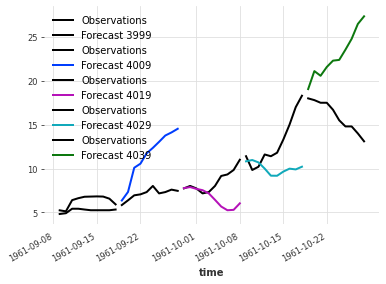

In [43]:
WSID = 869
prd = -1
fcst_len = 10
fcst_int = 10
fcst_n = 5
start = 3999

# Forecasts
fcst_list = []
for n in range(fcst_n):
    init = start+n*fcst_int

    val = val_list[WSID][prd][init][:fcst_len]
    val.plot(label='Observations', color='k')

    fcst = pred_list[WSID][prd][init][:fcst_len]
    fcst.plot(label=f'Forecast {init}')


In [ ]:
%%time
# test historical forecast

WSID = 869; prd = 0
ts_test = ts_series_test[WSID][prd]
cov_test = cov_series_test[WSID][prd]

# compute historical prediction
pred = model.historical_forecasts(ts_test, future_covariates=cov_test, start=270, forecast_horizon=10, 
                                  retrain=False, overlap_end=False, last_points_only=True, verbose=False)
# rescale
test_scaled = ts_scaler.inverse_transform(ts_test)
pred_scaled = ts_scaler.inverse_transform(pred)